# Import necessary packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # boxplot, histplot
import cv2

# The latest keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
import tensorflow as tf
#from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Rescaling, Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-qcwvyjm6
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-qcwvyjm6
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py) ... done


# Loading Data from Google Drive
Images in the original dataset have been converted into 256*256 .png format

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
#!ls "/content/gdrive/My Drive"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
df_train = pd.read_csv('/content/gdrive/My Drive/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/test.csv')
#df_train.info()
#df_test.info()
df_train['cancer'].unique()
df_train['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

# Data Exploration

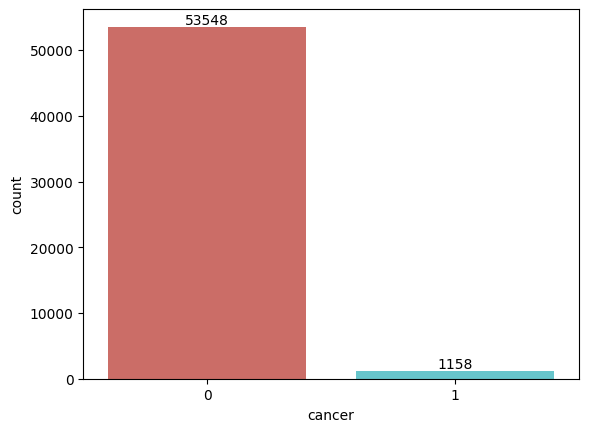

Percentage of benign class is: 97.8832303586444
Percentage of Malign class is: 2.11676964135561


In [4]:
def plot_precentage(df):
  ax=sns.countplot(x='cancer', data=df, palette='hls')
  plt.bar_label(ax.containers[0])
  plt.show()
  count_benign = len(df[df['cancer']==0])
  count_malign = len(df[df['cancer']==1])
  pct_of_benign = count_benign/(count_benign+count_malign)
  print("Percentage of benign class is:", pct_of_benign*100)
  pct_of_malign = count_malign/(count_benign+count_malign)
  print("Percentage of Malign class is:", pct_of_malign*100)

plot_precentage(df_train)

Observation: The original dataset is extremely imbalance. If build model based on this original dataset, the result will be overfitted as the majority class, i.e. the positive result. We must balance the data before creating the model. In this case, we decided to reduce the number of the majority class, the benign.


# Data Preprocessing
## Balance the data

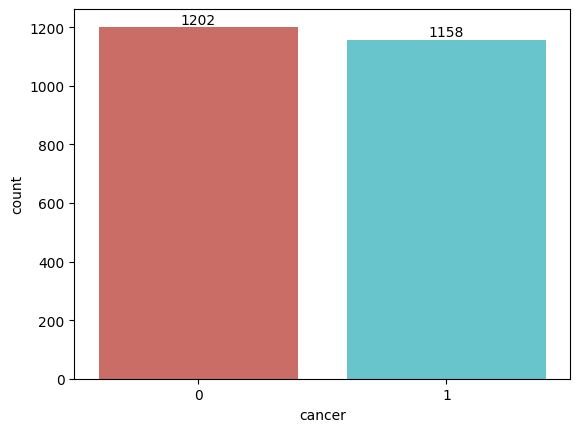

Percentage of benign class is: 50.93220338983051
Percentage of Malign class is: 49.06779661016949


In [5]:
df_benign = df_train[df_train['cancer'] == 0]
df_malign = df_train[df_train['cancer'] == 1]

df_benign = df_benign.sample(n=1202)

df_sample = pd.concat([df_benign, df_malign])

plot_precentage(df_sample)

Observation: Now we have a almost perfect balanced sample dataset!

In [6]:
# Create image_name matching the name in the image name directory by concatenating the patient_id and image_id
df_sample['image_name'] = df_sample["patient_id"].astype(str) + '_' + df_sample["image_id"].astype(str)
df_test['image_name'] = df_test["patient_id"].astype(str) + '_' + df_test["image_id"].astype(str)

In [7]:
# The append_ext function is defined to append extension to the image name
# Note
def append_ext(fname):
  if fname.endswith('.png'):
    print('Silly code: Do not add suffix twice.')
  else: return fname+'.png'

df_sample['image_name']=df_sample['image_name'].apply(append_ext)
print(df_sample.head())

df_test['image_name']=df_test['image_name'].apply(append_ext)
print(df_test.head())

       site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
20316        2       31523  1395211008          R   CC  50.0       0       0   
41431        2       54774  1936251802          R  MLO  66.0       0       0   
49629        1       63563  1678459732          L  MLO  56.0       0       0   
5864         1       16361   600399615          R  MLO  42.0       0       0   
13088        2       24001   911473467          R   CC  61.0       0       0   

       invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
20316         0     NaN        0     NaN          48                    False   
41431         0     NaN        0     NaN          21                    False   
49629         0     1.0        0       B          93                    False   
5864          0     1.0        1     NaN          49                    False   
13088         0     NaN        0     NaN          21                    False   

                 image_name  
20

# Split the sample dataset into training set and validation set:
   

*   training set contains 80% records, and validation set has the rest 20% instances.
*   Keras ImageDataGenerator to map the images in the RSNA_256 directory to the class cancer in the corresponing df_sample.
*   The batch_size of the training set and the validation set has set as the number that divides the total number of images in the train set and valid respectively.






In [8]:
# Source Code: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
# Modified by Jia Lin
datagen=ImageDataGenerator(validation_split =0.2)
train_generator=datagen.flow_from_dataframe(dataframe=df_sample,
                                            directory="/content/gdrive/My Drive/RSNA_256/",
                                            x_col="image_name",
                                            y_col="cancer",
                                            subset="training",
                                            batch_size=59, # 1888 = 32*59
                                            seed=40,
                                            shuffle=True,
                                            color_mode="grayscale", # the original dataset only gray
                                            class_mode="raw", # 'cancer' is numerical datatype
                                            target_size=(256,256))
valid_generator=datagen.flow_from_dataframe(dataframe=df_sample,
                                            directory="/content/gdrive/My Drive/RSNA_256/",
                                            x_col="image_name",
                                            y_col="cancer",
                                            subset="validation",
                                            batch_size=59, # 472 = 8*59
                                            seed=40,
                                            shuffle=True,
                                            color_mode="grayscale",
                                            class_mode="raw", # 'cancer' is numerical datatype
                                            target_size=(256,256))

Found 1888 validated image filenames.
Found 472 validated image filenames.


In [15]:
# This display function is used to present a list of images
def display(images, row, col):
  fig = plt.figure(figsize=(15, 15))
  for i in range(len(images)):
    fig.add_subplot(row,col,i+1)
    fig.tight_layout(h_pad=-30, w_pad=0)
    plt.imshow(images[i])
    plt.axis('off')

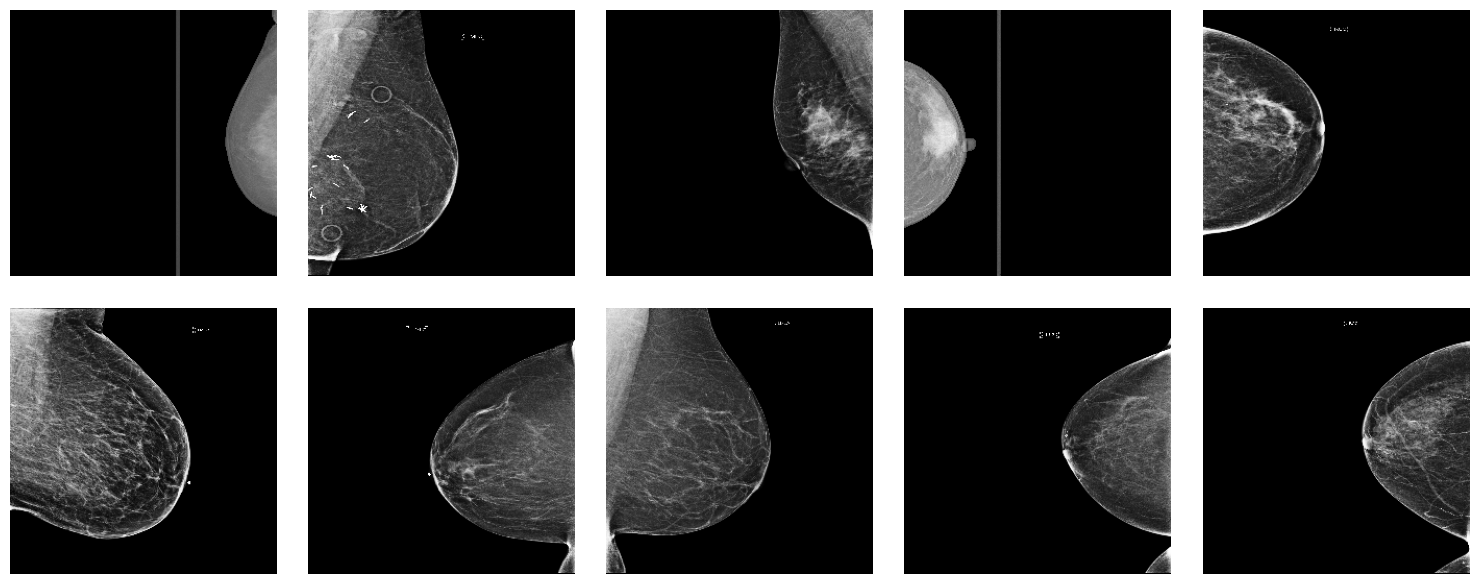

In [16]:
train_path = "/content/gdrive/My Drive/RSNA_256/"
train_images_path = os.listdir(train_path)
train_images = []
for img in train_images_path[:10]:# Only get the first 10 images
  img_path = os.path.join(train_path, img)
  img = cv2.imread(img_path)
  train_images.append(img)
display(train_images, 2, 5)

In [17]:
test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory="/content/gdrive/My Drive/testing_images/",
                                                x_col="image_name",
                                                y_col=None,
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                color_mode="grayscale",
                                                class_mode=None,
                                                target_size=(256,256))

Found 4 validated image filenames.


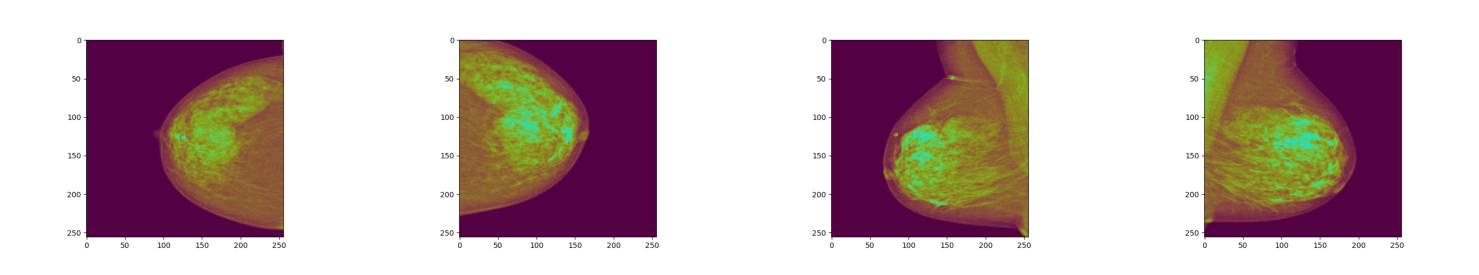

In [18]:
test_path = "/content/gdrive/My Drive/testing_images/"
test_images_path = os.listdir(test_path)
test_images = []
for img in test_images_path:
  img_path = os.path.join(test_path, img)
  img = cv2.imread(img_path)
  test_images.append(img)
display(test_images, 1, 4)

# Build the model:

In [20]:
# Define the CNN model
model = Sequential()

model.add(Rescaling(1./255, offset=0.0, input_shape=(256,256,1)))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(2, activation='softmax')) # Two classes output

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 16)      160       
                                                                 
 activation_5 (Activation)   (None, 256, 256, 16)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      4640      
                                                                 
 activation_6 (Activation)   (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                      

In [22]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fitting/Training the model

In [23]:
model.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
32/32 [==============================] - 880s 27s/step - loss: 0.8030 - accuracy: 0.5943 - val_loss: 0.8818 - val_accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 803s 25s/step - loss: 0.6523 - accuracy: 0.6186 - val_loss: 1.0043 - val_accuracy: 0.0657
Epoch 3/10
32/32 [==============================] - 828s 26s/step - loss: 0.6241 - accuracy: 0.6414 - val_loss: 1.0924 - val_accuracy: 0.2436
Epoch 4/10
32/32 [==============================] - 782s 24s/step - loss: 0.5800 - accuracy: 0.7108 - val_loss: 1.1870 - val_accuracy: 0.2903
Epoch 5/10
32/32 [==============================] - 824s 26s/step - loss: 0.4530 - accuracy: 0.7685 - val_loss: 1.3820 - val_accuracy: 0.3602
Epoch 6/10
32/32 [==============================] - 835s 26s/step - loss: 0.2882 - accuracy: 0.8665 - val_loss: 2.1726 - val_accuracy: 0.3729
Epoch 7/10
32/32 [==============================] - 833s 26s/step - loss: 0.1569 - accuracy: 0.9301 - val_loss: 3.4700 - val_accuracy: 0.3496
Ep

# Evaluate the model


In [24]:
model.evaluate(valid_generator)

8/8 [==============================] - 56s 7s/step - loss: 6.6030 - accuracy: 0.3559


[6.60297155380249, 0.35593220591545105]

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
pred = model.predict(valid_generator)
pred = np.argmax(pred, axis=1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(valid_generator.labels, pred)
print(confusion_matrix)

target_names = ['Benign','Malign']
print(classification_report(valid_generator.labels, pred, target_names=target_names, zero_division=0))

8/8 [==============================] - 48s 6s/step
Confusion Matrix
[[168 304]
 [  0   0]]
              precision    recall  f1-score   support

      Benign       1.00      0.36      0.53       472
      Malign       0.00      0.00      0.00         0

    accuracy                           0.36       472
   macro avg       0.50      0.18      0.26       472
weighted avg       1.00      0.36      0.53       472



# Predict the output

In [26]:
filenames = test_generator.filenames
number_test_samples = len(filenames)
test_generator.reset()
pred = model.predict(test_generator, number_test_samples)
pred = np.argmax(pred, axis = 1)
print(pred)

4/4 [==============================] - 2s 350ms/step
[1 1 1 1]
